In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [99]:
train = pd.read_csv('digit-recognizer/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
X = torch.from_numpy(train.drop('label', axis=1).values).type(torch.FloatTensor)
y = torch.from_numpy(train.label.values).type(torch.LongTensor)

In [101]:
split = 0.9
size = len(X)

Xtrain, Xval = X[:int(split*size)], X[int(split*size):]
ytrain, yval = y[:int(split*size)], y[int(split*size):]

In [102]:
# creating 28 by 28 images
Xtrain = Xtrain.view(-1, 1, 28, 28)
Xval = Xval.view(-1, 1, 28, 28)

In [104]:
# datasets
trainset = torch.utils.data.TensorDataset(Xtrain, ytrain)
validset = torch.utils.data.TensorDataset(Xval, yval) 

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)
validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=False)

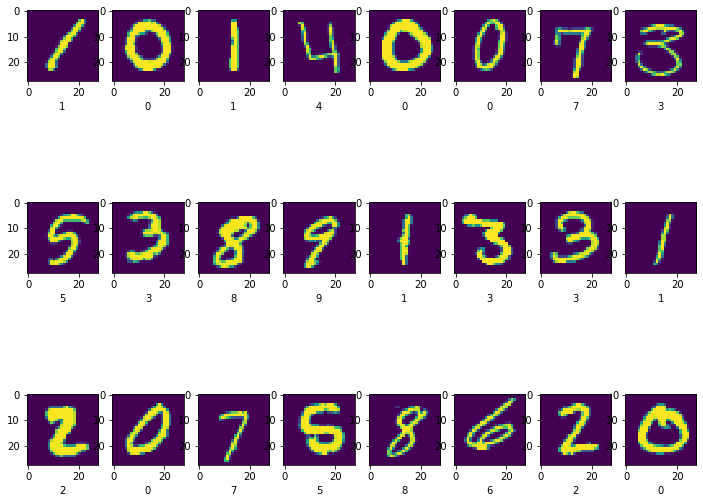

In [105]:
images, labels = next(iter(trainloader))

fig = plt.figure(figsize=(12, 10))
x, y = 8 ,3
for i in range(24):
    plt.subplot(y, x, i+1)
    plt.imshow(images[i][0])
    plt.xlabel(labels[i].item())
plt.show()

In [106]:
gpu_check = torch.cuda.is_available()
gpu_check

False

In [107]:
def conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(2, 2))
        
    return nn.Sequential(*layers)

In [134]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = conv(1, 32)
        self.conv2 = conv(32, 64)
        self.conv3 = conv(64, 128)
        self.conv4 = conv(128, 512)
        
        self.fc1 = nn.Linear(512*1*1, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(p=.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.dropout(x)
        
        x = x.view(-1,512*1*1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [135]:
model = Net()
model

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): D

In [136]:
if gpu_check:
    model = model.cuda()

In [137]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [138]:
def train(epochs, trainloader, validloader, model, optimizer, criterion, gpu_check):
    
    validation_loss_Inf = np.Inf
    
    for epoch in range(1, epochs+1):
        
        train_loss, valid_loss = 0, 0
        
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            
            if gpu_check:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if gpu_check:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model.forward(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        return model

In [139]:
model = train(50, trainloader, validloader, model, optimizer, criterion, gpu_check)

Epoch: 1 	Training Loss: 2.506454 	Validation Loss: 2.303827


In [91]:
def test(loaders, model, criterion, gpu_check):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if gpu_check:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, gpu_check)

NameError: name 'loaders_scratch' is not defined

# TESTING ON THE DATASET 

In [13]:
test_data = pd.read_csv('../input/digit-recognizer/test.csv')
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
test_data_torch = torch.from_numpy(test_data.values).type(torch.FloatTensor)
test_data_torch = test_data_torch.view(-1, 1, 28, 28)

In [15]:
test_data_torch.shape

torch.Size([28000, 1, 28, 28])

In [16]:
model.eval()
test_Images = Variable(test_data_torch).float()
output = model(test_Images)
y_pred = torch.max(output, 1)[1]

In [17]:
# checking all values are being predicted
y_pred.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
y_pred

tensor([2, 0, 9,  ..., 3, 9, 2])

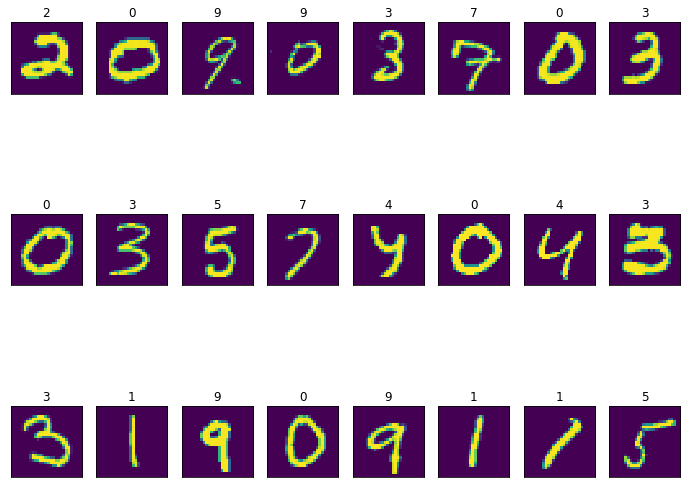

In [19]:
# visualize the predictions
fig = plt.figure(figsize=(12, 10))
x, y = 8 ,3
for i in range(24):
    ax = plt.subplot(y, x, i+1,xticks=[], yticks=[])
    ax.imshow(test_data_torch[i].reshape(28, 28))
    ax.set_title(f"{y_pred[i].item()}")

In [20]:
# saving the model
torch.save(model.state_dict(), 'pytorch_model.pt')

In [21]:
# creating the submission file
submission = pd.DataFrame({"ImageId":[i+1 for i in range(len(test_data_torch))],
                           "Label": y_pred})
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [22]:
submission.to_csv("submission_with_pytorch_2.csv", index=False, header=True)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 